In [1]:
# libraries
import matplotlib.pyplot as plt
%matplotlib widget
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import tqdm
from itertools import accumulate
from synchron_ad import SynchronMaskEstimator


# custom
import utilities
import synchronization_heads.synchronization_utils as synchronization_utils 
import torch.nn.functional as F

# plotting
WIDTH = 12
HEIGHT = 3

In [2]:
MACHINE = 'BrushlessMotor' # BrushlessMotor, RoboticArm
# Paths to the training and testing HDF5 dataset files
TRAIN_DATASET_PATH = f'data/{MACHINE}/windowed/train_dataset_window_0.100s.h5'
TEST_DATASET_PATH = f'data/{MACHINE}/windowed/test_dataset_window_0.100s.h5'

# List of sensor names to be extracted from the dataset
SENSORS = [
    'imp23absu_mic',
    'ism330dhcx_acc',
    'ism330dhcx_gyro'
]

# List of label names to be extracted from the dataset
LABEL_NAMES = ['segment_id',
               'split_label',
               'anomaly_label',
               'domain_shift_op',
               'domain_shift_env']


PARAMS = {
    'batch_size': 64,
    'num_epochs': 1000,
    'lr': 0.001,
    # TO BE ADAPTED TO YOUR MACHINE: either 'mps or 'cuda' if GPU available,
    # otherwise 'cpu'
    'device': 'mps',
    'patience': 3,
    'normalisation': 'std_window',
    'valid_size': 0.1,
    'seed': 1995,
}


# Load the dataset
X_train_raw, Y_train_raw, X_test, Y_test = utilities.load_dataset(
    TRAIN_DATASET_PATH, TEST_DATASET_PATH, LABEL_NAMES, SENSORS)

# Set the seed for general torch operations
torch.manual_seed(PARAMS['seed'])
# Set the seed for MPS torch operations (ones that happen on the MPS Apple GPU)

if PARAMS['device'] == 'mps':
    torch.mps.manual_seed(PARAMS['seed'])
elif PARAMS['device'] == 'cuda':
    torch.cuda.manual_seed(PARAMS['seed'])
elif PARAMS['device'] == 'cpu':
    torch.manual_seed(PARAMS['seed'])
else:
    raise ValueError(f"Unsupported device type: {PARAMS['device']}")


# Load the dataset
X_train_raw, Y_train_raw, X_test, Y_test = utilities.load_dataset(
    TRAIN_DATASET_PATH, TEST_DATASET_PATH, LABEL_NAMES, SENSORS)

# Combine anomaly labels and domain shift labels to form a combined label
Y_train_raw['combined_label'] = Y_train_raw['anomaly_label'] + \
    Y_train_raw['domain_shift_op'] + Y_train_raw['domain_shift_env']
Y_test['combined_label'] = Y_test['anomaly_label'] + \
    Y_test['domain_shift_op'] + Y_test['domain_shift_env']

# Split training data into training and validation sets, maintaining the
# stratified distribution of the combined label
train_indices, valid_indices, _, _ = train_test_split(
    range(len(Y_train_raw)),
    Y_train_raw,
    stratify=Y_train_raw['combined_label'],
    test_size=PARAMS['valid_size'],
    random_state=PARAMS['seed']
)

# Select the training and validation data based on the indices
X_train = [sensor_data[train_indices] for sensor_data in X_train_raw]
X_valid = [sensor_data[valid_indices] for sensor_data in X_train_raw]
Y_train = Y_train_raw.iloc[train_indices].reset_index(drop=True)
Y_valid = Y_train_raw.iloc[valid_indices].reset_index(drop=True)

# Normalize the training, validation, and test datasets using the
# specified normalization method
X_train, X_valid, X_test = utilities.normalize_data(
    X_train, X_valid, X_test, PARAMS['normalisation'])

# Extract the number of channels and window lengths for each sensor
NUM_CHANNELS = {SENSORS[i]: x.shape[1] for i, x in enumerate(X_train)}
WINDOW_LENGTHS = {SENSORS[i]: x.shape[2] for i, x in enumerate(X_train)}


X_train_tensor = [torch.from_numpy(x) for x in X_train]
X_valid_tensor = [torch.from_numpy(x) for x in X_valid]
X_test_tensor = [torch.from_numpy(x) for x in X_test]

train_dataset = utilities.CustomDataset(X_train_tensor)
valid_dataset = utilities.CustomDataset(X_valid_tensor)
test_dataset = utilities.CustomDataset(X_test_tensor)

train_data_loader = DataLoader(
    train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
valid_data_loader = DataLoader(
    valid_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
test_data_loader = DataLoader(
    test_dataset, batch_size=PARAMS['batch_size'], shuffle=False)

In [3]:
# Define the lambda parameter
lambda_ = 0.8
sync_head_conv_parameters = synchronization_utils.initialize_parameters(
    SENSORS, WINDOW_LENGTHS, NUM_CHANNELS, lambda_=lambda_)

Skipping ism330dhcx_gyro as it has the same window length as another
Optimum window length: 1537, corresponding lambda: 0.7900959561343386
For sensor imp23absu_mic there are 84 solutions
For sensor ism330dhcx_acc there are 1 solutions
For sensor ism330dhcx_gyro there are 1 solutions


In [4]:
import importlib
import synchron_ad
importlib.reload(synchron_ad)
from synchron_ad import SynchronMaskEstimator

In [5]:
model_params = {
"sync_method": 'sync_head_conv',# 'sync_head_conv', 'sync_head_fc' , 'resample_interp', 'resample_fft', 'zeropad'
"desynchronization_method": 'conv', # 'fc' or 'conv',
"C_sync": 1,
"C_fuse": 4,
"kernel_size": 15,
"fc_num_layers": 1
}

model = SynchronMaskEstimator(params=PARAMS,
                            sensors=SENSORS,
                            num_channels=NUM_CHANNELS,
                            window_lengths=WINDOW_LENGTHS,
                            c_sync=model_params['C_sync'],
                            c_fuse=model_params['C_fuse'],
                            kernel_size=model_params['kernel_size'],
                            desynchronization_method=model_params['desynchronization_method'], 
                            sync_method=model_params['sync_method'],
                            fc_num_layers=model_params['fc_num_layers'],
                            sync_head_conv_parameters=sync_head_conv_parameters,
                            ).to(PARAMS['device'])

optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['lr'])
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
model

Total number of parameters: 141960


SynchronMaskEstimator(
  (synchronizer): SynchronizationBlock(
    (sync_heads): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 1, kernel_size=(15,), stride=(1,), dilation=(3,))
        (1): ReLU()
        (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(1, 1, kernel_size=(8,), stride=(1,), dilation=(3,))
        (4): ReLU()
        (5): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1-2): 2 x Sequential(
        (0): ConvTranspose1d(3, 3, kernel_size=(15,), stride=(1,), dilation=(3,), groups=3)
        (1): ReLU()
        (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ConvTranspose1d(3, 3, kernel_size=(15,), stride=(2,), dilation=(3,), groups=3)
        (4): ReLU()
        (5): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (fusing_block): PMCE(
    (mask_module): MaskOutOn

In [6]:
model.fit(train_data_loader, valid_data_loader, optimizer, PARAMS['num_epochs'], PARAMS['patience'],verbose=True)

----------- Epoch 1 -----------


----------- Epoch 2 -----------


----------- Epoch 3 -----------


----------- Epoch 4 -----------


----------- Epoch 5 -----------


----------- Epoch 6 -----------


----------- Epoch 7 -----------


----------- Epoch 8 -----------


----------- Epoch 9 -----------


----------- Epoch 10 -----------


----------- Epoch 11 -----------


----------- Epoch 12 -----------


----------- Epoch 13 -----------


----------- Epoch 14 -----------


Stopping early due to no improvement in validation loss.


([1.439959244261434,
  0.048681363345846385,
  0.041924791846331105,
  0.040925898310506435,
  0.04052046874499554,
  0.040294589760578495,
  0.04014283120307881,
  0.04001817603365511,
  0.039922160324483494,
  0.03987385283535401,
  0.03984280584848225,
  0.039820631838305344,
  0.03980647670398988,
  0.039800656560131466],
 [0.06375448720403087,
  0.04295131433935999,
  0.04199908550792528,
  0.040595074265616614,
  0.04022394619809771,
  0.04044107289858235,
  0.039983700165181484,
  0.04034667436793012,
  0.04007449301267133,
  0.039949257252285784,
  0.04061065075322262,
  0.041138726639226804,
  0.040725195436801725,
  0.040080717502577794])

In [7]:
inputs, outputs = model.predict(test_data_loader)
labels = Y_test['combined_label'].values

In [8]:
# compute MSE of normal and 1 masked sensor version
sensor_losses = torch.cat([((x_sensor - x_sensor_out)**2).mean(0).mean(1)
                          for x_sensor, x_sensor_out in zip(inputs, outputs)]).cpu().detach().numpy()

Sensor: imp23absu_mic, Losses on channels: 0.017
Sensor: ism330dhcx_acc, Losses on channels: 0.000, 0.000, 0.000
Sensor: ism330dhcx_gyro, Losses on channels: 0.000, 0.000, 0.000
Label: beltspd1800BckgD Overall MSE: 0.018


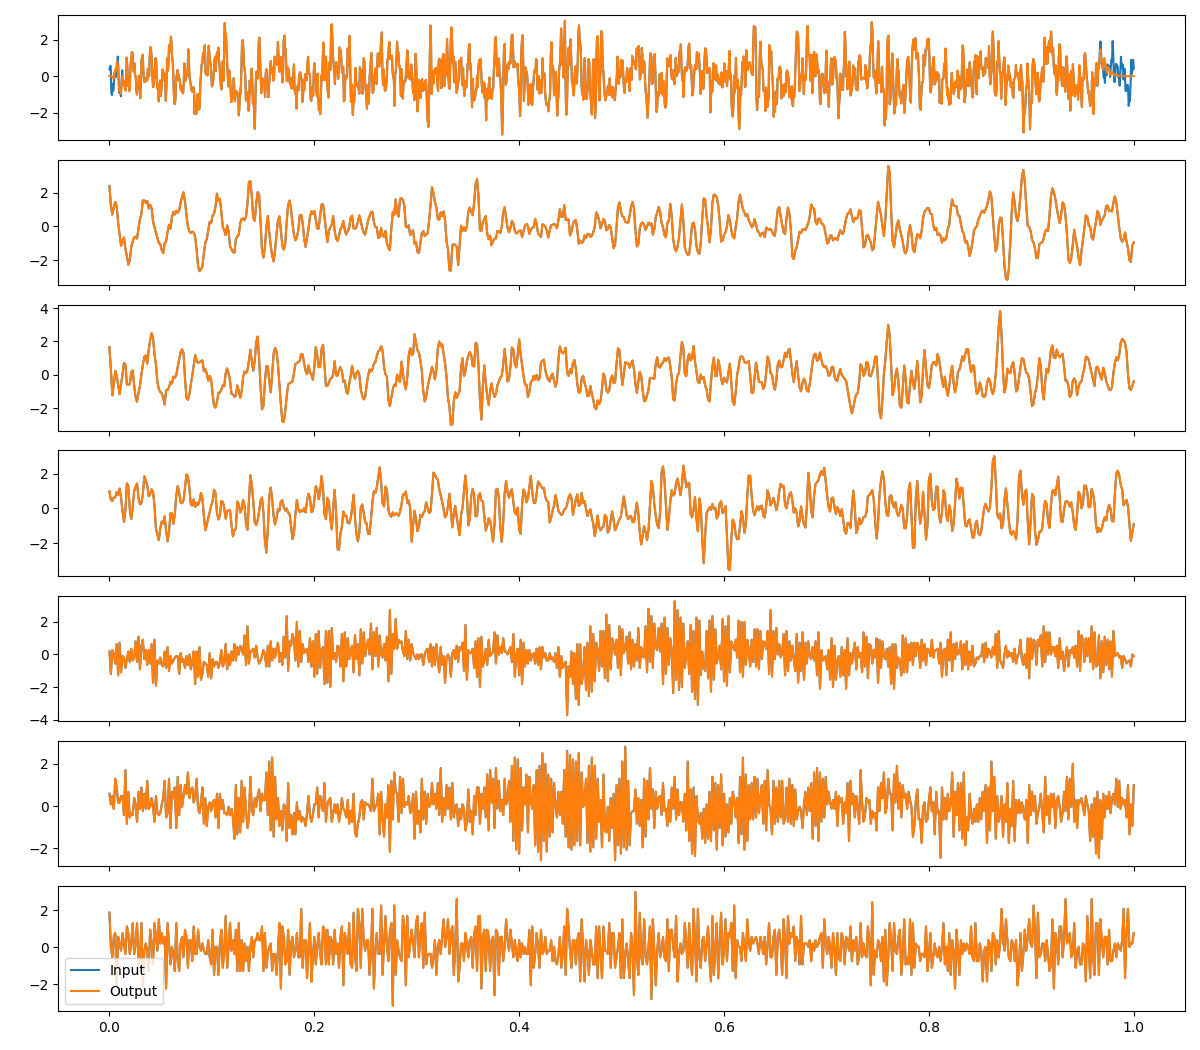

In [17]:
sample = np.random.randint(0, len(inputs[0]))
total_plot = sum([NUM_CHANNELS[sensor] for sensor in SENSORS])
plt.close('all')
fig, axs = plt.subplots(total_plot, 1, figsize=(
    WIDTH, HEIGHT * total_plot * 0.5), sharex=True)

i = 0
overall_MSE = 0
for sensor_idx, sensor in enumerate(SENSORS):
    sensor_losses = []
    for channel_idx in range(NUM_CHANNELS[sensor]):
        t = np.linspace(0, 1, WINDOW_LENGTHS[sensor])
        input = inputs[sensor_idx][sample, channel_idx].cpu().numpy()
        output = outputs[sensor_idx][sample, channel_idx].detach().cpu().numpy()
        # Calculate loss on output
        loss_output = ((input - output)**2).mean(0)
        sensor_losses.append(f"{loss_output:.3f}")

        axs[i].plot(t, input, label='Input')
        axs[i].plot(t, output, label='Output')
        i += 1
        overall_MSE += loss_output
    print(f"Sensor: {sensor}, Losses on channels: {', '.join(sensor_losses)}")

print(f"Label: {labels[sample]} Overall MSE: {overall_MSE:.3f}")
plt.legend()
plt.tight_layout()
